## Instal·lant dependències

In [1]:
import os
from fastai import *
from fastai.text import *
from gensim.corpora import WikiCorpus

import numpy as np
import pandas as pd

from pathlib import Path
from functools import partial

In [ ]:
!pip install sacremoses

In [ ]:
!nvidia-smi

Wed Aug 19 13:59:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Descarreguem el Wikipedia dump en català

In [38]:
!rm -rf data/wiki_extr
!rm -rf wikiextractor/ WikiExtractor.py

In [39]:
!sh get_wikimedia.sh

INFO: 42856	Ray Bradbury
INFO: 42859	I Concurs de castells de Tarragona
INFO: 42861	Corvus
INFO: 42865	Tasi\xe0
INFO: 42870	Naqada
INFO: 42871	Benasc
INFO: 42874	Constel\xb7laci\xf3 del Dof\xed
INFO: 42875	Naqada I
INFO: 42876	Parc Natural de Pocets-Maladeta
INFO: 42877	Naqada II
INFO: 42879	Nubt
INFO: 42882	Faium
INFO: 42887	Birket Qarun
INFO: 42889	Karun
INFO: 42891	Alt Egipte
INFO: 42892	Luar na Lubre
INFO: 42894	Nekhen
INFO: 42895	Kom al-Ahmar
INFO: 42897	Esna
INFO: 42898	Temple de Khnum (Esna)
INFO: 42899	Edf\xfa
INFO: 42902	Lat\xf2polis
INFO: 42912	Temple d'Edf\xfa
INFO: 42913	Nil\xf2metre
INFO: 42914	Baix Egipte
INFO: 42915	Paleta de Narmer
INFO: 42918	Museu d'Antiguitats Eg\xedpcies
INFO: 42920	Xesmetet
INFO: 42921	Encens
INFO: 42925	Furs
INFO: 42927	II Concurs de castells de Tarragona
INFO: 42932	Illes del Vent
INFO: 42936	Na\xfcja
INFO: 42938	Oceja
INFO: 42941	Palau de Cerdanya
INFO: 42942	Plan\xe8s
INFO: 42944	Porta (Alta Cerdanya)
INFO: 42945	Gebelein
INFO: 42946	Abadiya
IN

In [40]:
name = 'CatalanULMFit'
model_dir = 'models'
model_dir = Path(model_dir)
model_dir.mkdir(exist_ok=True)

Creem el corpus

In [ ]:
!ls data/wiki_extr/ca

AA  AB	AC  AD	AE  AF	AG  AH	AI  AJ	AK  AL	AM


In [42]:
!python create_wikiText.py -i data/wiki_extr/ca -o data/wiki -l ca

Writing to data/wiki/ca-2/ca.wiki.train.tokens...
data/wiki/ca-2/ca.wiki.train.tokens. # documents: 1,543. # tokens: 2,001,511.
Copying data/wiki/ca-2/ca.wiki.train.tokens to data/wiki/ca-100/ca.wiki.train.tokens.
Writing to data/wiki/ca-2/ca.wiki.valid.tokens...
data/wiki/ca-2/ca.wiki.valid.tokens. # documents: 160. # tokens: 200,121.
Copying data/wiki/ca-2/ca.wiki.valid.tokens to data/wiki/ca-100/ca.wiki.valid.tokens.
Writing to data/wiki/ca-2/ca.wiki.test.tokens...
data/wiki/ca-2/ca.wiki.test.tokens. # documents: 143. # tokens: 204,189.
Copying data/wiki/ca-2/ca.wiki.test.tokens to data/wiki/ca-100/ca.wiki.test.tokens.
Writing to data/wiki/ca-100/ca.wiki.train.tokens...
Processed 10,000 documents. Total # tokens: 12,679,823.
data/wiki/ca-100/ca.wiki.train.tokens. # documents: 12,051. # tokens: 15,237,977.


In [43]:
 !python postprocess_wikiText.py -i data/wiki -l ca

Replacing numbers in data/wiki/ca-2/ca.wiki.train.tokens. Writing to data/wiki/ca-2/ca.wiki.train.tokens.unk.
Replacing numbers in data/wiki/ca-2/ca.wiki.valid.tokens. Writing to data/wiki/ca-2/ca.wiki.valid.tokens.unk.
Replacing numbers in data/wiki/ca-2/ca.wiki.test.tokens. Writing to data/wiki/ca-2/ca.wiki.test.tokens.unk.
Replacing numbers in data/wiki/ca-100/ca.wiki.train.tokens. Writing to data/wiki/ca-100/ca.wiki.train.tokens.unk.
Replacing numbers in data/wiki/ca-100/ca.wiki.valid.tokens. Writing to data/wiki/ca-100/ca.wiki.valid.tokens.unk.
Replacing numbers in data/wiki/ca-100/ca.wiki.test.tokens. Writing to data/wiki/ca-100/ca.wiki.test.tokens.unk.
OOV ratio: 0.0367.
ca-2 vocab size: 33699
OOV ratio: 0.0151.
ca-100 vocab size: 117184
Limiting vocab in data/wiki/ca-2/ca.wiki.train.tokens.unk. Writing to data/wiki/ca-2/ca.wiki.train.tokens.unk.
ca.wiki.train.tokens.unk. # of tokens: 2006545
Limiting vocab in data/wiki/ca-2/ca.wiki.valid.tokens.unk. Writing to data/wiki/ca-2/ca

In [2]:
trn_path = Path('data/wiki/ca-2/ca.wiki.train.tokens')
val_path = Path('data/wiki/ca-2/ca.wiki.valid.tokens')

with open(trn_path, encoding='utf8') as f:
  text = f.readlines()

df_train = pd.DataFrame(
  {'content': np.array(text), 'is_valid': np.zeros(len(text))},
  columns=['content', 'is_valid'])

with open(val_path, encoding='utf8') as f:
      text2 = f.readlines()

df_valid = pd.DataFrame(
    {'content': np.array(text2), 'is_valid': np.ones(len(text2))},
    columns=['content', 'is_valid'])
  
df_regroup = pd.concat([df_train, df_valid])
df_regroup.to_csv('data/wiki/full_train.csv', header=None, index=None)

In [4]:
tokenizer = Tokenizer(lang='ca', n_cpus=6)
data_lm_full = (TextList.from_csv('data/wiki', csv_name='full_train.csv', cols=0, processor=[TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=60000)])
           #Inputs: all the text files in path
            .split_from_df(col=1)
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=32))


In [8]:
!du -H data/wiki/full_train.csv

11732	data/wiki/full_train.csv


In [10]:
itos = data_lm_full.train_ds.vocab.itos
print('Size of vocabulary:', len(itos))
print('First 10 words in vocab:', ', '.join([itos[i] for i in range(10)]))

Size of vocabulary: 31376
First 10 words in vocab: xxunk, xxpad, xxbos, xxeos, xxfld, xxmaj, xxup, xxrep, xxwrep, ,


In [ ]:
torch.cuda.is_available()

True

# Entrenar el Language Model

Hem usat com a dataset tot el text que s'ha trobat en el repositori https://github.com/Softcatala/ca-text-corpus. També hem provat d'entrenar amb un dataset creat a partir del script **./get_wikimedia.sh** però ens tornava un dataset massa brut. 

In [17]:
learn = language_model_learner(data_lm_full,  arch=AWD_LSTM, drop_mult=0, callback_fns=ShowGraph)

In [20]:
# save vocabulary
print('Saving vocabulary...')
with open(os.path.join('data', 'itos.pkl'), 'wb') as f:
    pickle.dump(itos, f)

Saving vocabulary...


In [22]:
data_lm_full.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"valencià . xxmaj la seua poesia , en llengua catalana , tingué una repercussió notable en la lírica castellana del segle xxup xvi al xxup xviii . s ' han conservat 128 poemes d ' xxmaj ausiàs xxmaj march provinents dels manuscrits i edicions antigues , que han estat classificats sovint segons la temàtica : d ' amor , de mort , morals i espirituals . \n xxbos \n"
1,"leipzig , xxmaj berlín i xxmaj budapest . xxmaj el 1796 , va publicar tres sonates per a piano ( & ' xxmaj opus 2 & ' ) . xxmaj la cort , la noblesa i l ' xxmaj església xxunk van acollir la música de xxmaj beethoven i es van convertir en mecenes i xxunk del jove músic . xxmaj eren freqüents les disputes en aquests estaments i el"
2,"desembarcant a xxmaj pollença ) en el seu enfrontament amb xxmaj pere el xxmaj cerimoniós . xxmaj jaume xxup iii provà de recuperar l ' illa el 1349 , sense succés , després de desembarcar a xxmaj formentor i enfrontar - se a l ' exèrcit reial a la vila de xxmaj pollença , la qual fou saquejada . xxmaj la xxmaj revolta xxmaj forana el tengué participació xxunk i"
3,"xxmaj bells , aquest no guarda una estructura de tipus & ' simfonia amb menuts moviments & ' . xxmaj més aviat es tracta de pistes independents que , això sí , guarden cert paregut amb algunes de les pistes dels altres dos discos & ' tubulars & ' . xxmaj amb aquest disc xxmaj mike torna a demostrar que encara no ha xxunk del xxunk musical que va tenir"
4,"grup i on la interpretació és una part fonamental del producte artístic . \n xxbos \n xxbos xxmaj els productes de les arts escèniques en general són espectacles que poden incloure , xxunk o mesclats , alguns d ' aquests gèneres . l ' obra d ' art pròpia de les arts escèniques és l ' espectacle dramàtic , que consisteix a una presentació davant d ' un"


In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


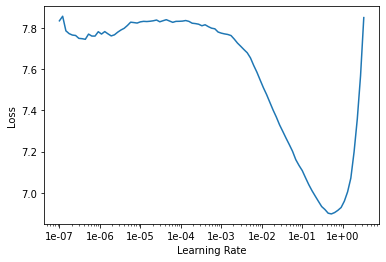

In [25]:
learn.recorder.plot(skip_start=0)

In [26]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [ ]:
 learn.fit_one_cycle(5, 5e-3, moms=(0.8, 0.7))

In [ ]:
 learn.fit_one_cycle(1, 5e-3, moms=(0.8, 0.7))

In [ ]:
learn.save('model_60k-vocab')

In [ ]:
np.exp(3.25)

25.790339917193062